```
This software is part of GPU Ocean. 

Copyright (C) 2022, 2024 SINTEF Digital

Notebook to prototype the support of atmospheric pressure into 
the simplified ocean models

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Test bed for atmospheric pressure

This notebook is used to implement and test the inclussion of atmospheric pressure into GPU Ocean.

The shallow water equations with atmospheric pressure $p_s$, but without any other source terms (Coriolis, constant bathymetry, wind forcing, friction) are given by
$$
\left[ \begin{matrix} \eta \\ hu  \\ hv  \end{matrix}\right]_t + 
\left[ \begin{matrix} hu \\ hu^2 + \frac{1}{2}gh^2 \\ huv \end{matrix}\right]_x +
\left[ \begin{matrix} hv \\ huv \\ hv^2 + \frac{1}{2}gh^2 \end{matrix}\right]_y = 
\left[ \begin{matrix} 0 \\ -\frac{h}{\rho_o} (p_s)_x  \\ -\frac{h}{\rho_o} (p_s)_y  \end{matrix}\right],
$$
with $\rho_o$ being the density of the sea water.

The lake-at-rest steady state of this equation is obtained by setting the time derivatives and velocities ($u$ and $v$) to zero.
In $x$-direction (2nd equation in the system), we are then left with
$$
    (\frac{1}{2}gh^2)_x = - \frac{h}{\rho_o}(p_s)_x.
$$
Using the chain rule, the left-hand-side becomes simply $g h h_x$. One of the $h$'s cancel, and we are left with
$$
h_x = -\frac{1}{\rho_o g} (p_s)_x.
$$
Since $h_x = \eta_x$ when the bathymetry is constant, the steady-state is described by
$$
\eta_x = -\frac{1}{\rho_o g} (p_s)_x \quad \text{and} \quad \eta_y = -\frac{1}{\rho_o g} (p_s)_y.
$$

This last expression is what we expect in $\eta$ from applying a non-constant atmospheric pressure to a flat ocean after sufficient time.



In [ ]:
from gpuocean.SWEsimulators import CDKLM16 
from gpuocean.utils import Common, IPythonMagic, AtmosphericPressure

import numpy as np

from matplotlib import pyplot as plt
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'



from importlib import reload

In [ ]:
%cuda_context_handler gpu_ctx

In [ ]:
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 500, "ny": 400, "dx": 800, "dy": 500,
    "g": 9.81, "dt": 0.0, "f": 0.0, "r": 0.0,
}

dataShape = (sim_args["ny"]+4, sim_args["nx"]+4)

init_args = {
    "eta0": np.zeros(dataShape, dtype=np.float32),
    "hu0" : np.zeros(dataShape, dtype=np.float32),
    "hv0" : np.zeros(dataShape, dtype=np.float32),
    "H"  : np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*100
}

balanced_init_args = {
    "eta0": np.zeros(dataShape, dtype=np.float32),
    "hu0" : np.zeros(dataShape, dtype=np.float32),
    "hv0" : np.zeros(dataShape, dtype=np.float32),
    "H"  : np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*100
}

balanced_init_args_linx = {
    "eta0": np.zeros(dataShape, dtype=np.float32),
    "hu0" : np.zeros(dataShape, dtype=np.float32),
    "hv0" : np.zeros(dataShape, dtype=np.float32),
    "H"  : np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*100
}

balanced_init_args_liny = {
    "eta0": np.zeros(dataShape, dtype=np.float32),
    "hu0" : np.zeros(dataShape, dtype=np.float32),
    "hv0" : np.zeros(dataShape, dtype=np.float32),
    "H"  : np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*100
}

balanced_init_args_linxy = {
    "eta0": np.zeros(dataShape, dtype=np.float32),
    "hu0" : np.zeros(dataShape, dtype=np.float32),
    "hv0" : np.zeros(dataShape, dtype=np.float32),
    "H"  : np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*100
}

def setWall(data):
    data[1,:] = data[2,:]
    data[0,:] = data[3,:]
    data[-2,:] = data[-3,:]
    data[-1,:] = data[-4,:]
    
    data[:,  1] = data[:, 2 ]
    data[:,  0] = data[:, 3 ]
    data[:, -2] = data[:, -3]
    data[:, -1] = data[:, -4]
    



(250,)


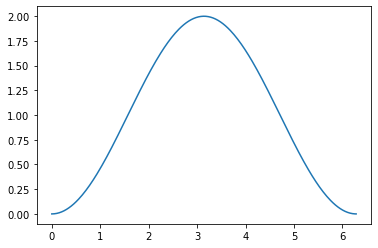

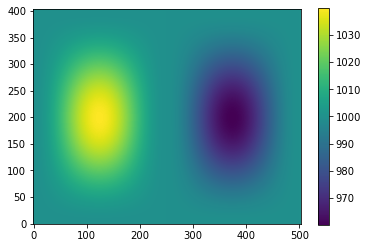

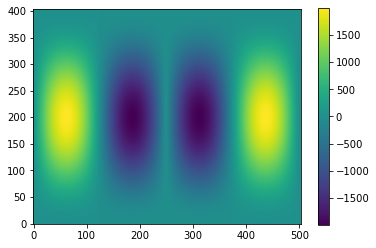

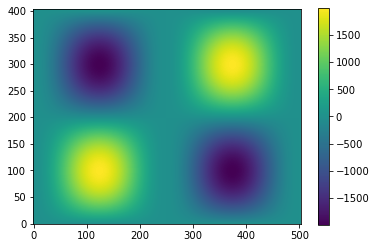

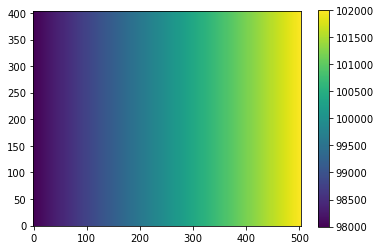

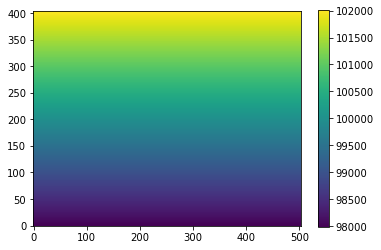

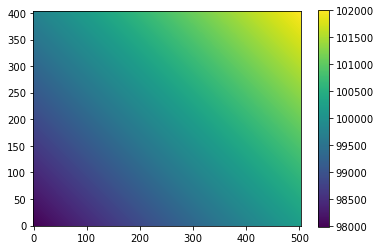

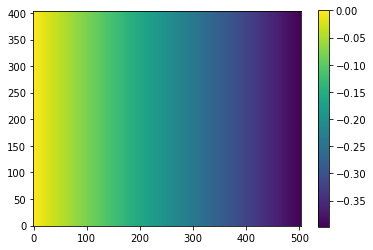

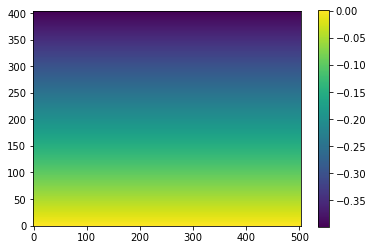

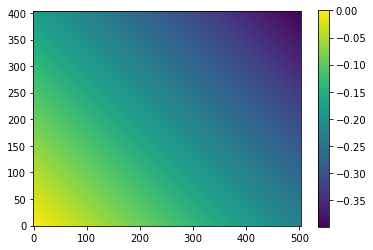

In [5]:
# Make pressure field

pa = np.ones(dataShape, np.float32)*100000
dpadx = np.zeros_like(pa)
dpady = np.zeros_like(pa)

pa_linear_x = np.ones(dataShape, np.float32)*100000
pa_linear_y = np.ones(dataShape, np.float32)*100000
pa_linear_xy = np.ones(dataShape, np.float32)*100000

x = np.linspace(0, 2*np.pi, int((dataShape[1]-4)/2))

print(x.shape)
plt.plot(x, 1 -  np.cos(x))
#plt.plot(x, np.cos(x))

y = np.linspace(0, 2*np.pi, dataShape[0]-4)

for i in range(len(x)):
    for j in range(len(y)):
        pa[j, i                        ] += 0.5*(1 - np.cos(x[i]))*(1 - np.cos(y[j]))*2000
        pa[j, i + int(sim_args["nx"]/2)] += 0.5*(np.cos(x[i]) - 1)*(1 - np.cos(y[j]))*2000
       
        # Derivative wrt x
        dpadx[j, i                        ] =  0.5*np.sin(x[i])*(1 - np.cos(y[j]))*2000
        dpadx[j, i + int(sim_args["nx"]/2)] = -0.5*np.sin(x[i])*(1 - np.cos(y[j]))*2000

        # Derivative wrt y
        dpady[j, i                        ] = 0.5*(1 - np.cos(x[i]))*np.sin(y[j])*2000
        dpady[j, i + int(sim_args["nx"]/2)] = 0.5*(np.cos(x[i]) - 1)*np.sin(y[j])*2000
 
 
        balanced_init_args["eta0"][j, i                        ] = -0.5*(1 - np.cos(x[i]))*(1 - np.cos(y[j]))*2000 / (sim_args["g"]*1025)
        balanced_init_args["eta0"][j, i + int(sim_args["nx"]/2)] = -0.5*(np.cos(x[i]) - 1)*(1 - np.cos(y[j]))*2000 / (sim_args["g"]*1025)

fullx = np.linspace(-1.5, sim_args["nx"]+1.5, sim_args["nx"]+4)
fully = np.linspace(-1.5, sim_args["ny"]+1.5, sim_args["ny"]+4)

for i in range(len(fullx)):
    for j in range(len(fully)):
        # Linear along x
        pa_linear_x[j, i]             += - 2000 + 4000*fullx[i]/ sim_args["nx"]
        balanced_init_args_linx["eta0"][j, i] = - 4000*fullx[i]/(sim_args["nx"] * (sim_args["g"]*1025))

        # Linear along y
        pa_linear_y[j, i]             += - 2000 + 4000*fully[j]/ sim_args["ny"]
        balanced_init_args_liny["eta0"][j, i] = - 4000*fully[j]/(sim_args["ny"] * (sim_args["g"]*1025))

        # Linear on the diagonal
        pa_linear_xy[j, i]             += - 2000 + 4000*(fullx[i] + fully[j])/ (sim_args["nx"] + sim_args["ny"])
        balanced_init_args_linxy["eta0"][j, i] = - 4000*(fullx[i] + fully[j])/((sim_args["nx"] + sim_args["ny"]) * (sim_args["g"]*1025))


#pa_linear_x  = setWall(pa_linear_x)
#pa_linear_y  = setWall(pa_linear_y)
#pa_linear_xy = setWall(pa_linear_xy)


fig = plt.figure()
plt.imshow(pa/100, origin="lower")
plt.colorbar()

fig = plt.figure()
plt.imshow(dpadx, origin="lower")
plt.colorbar()

fig = plt.figure()
plt.imshow(dpady, origin="lower")
plt.colorbar()


fig = plt.figure()
plt.imshow(pa_linear_x, origin="lower")
plt.colorbar()

fig = plt.figure()
plt.imshow(pa_linear_y, origin="lower")
plt.colorbar()

fig = plt.figure()
plt.imshow(pa_linear_xy, origin="lower")
plt.colorbar()

fig = plt.figure()
plt.imshow(balanced_init_args_linx["eta0"], origin="lower")
plt.colorbar()

fig = plt.figure()
plt.imshow(balanced_init_args_liny["eta0"], origin="lower")
plt.colorbar()

fig = plt.figure()
plt.imshow(balanced_init_args_linxy["eta0"], origin="lower")
plt.colorbar()



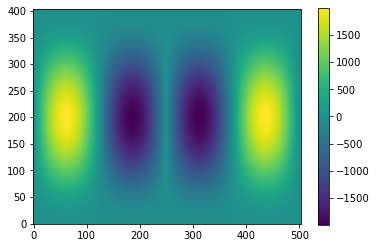

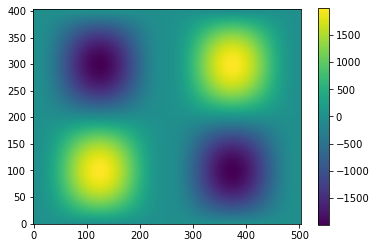

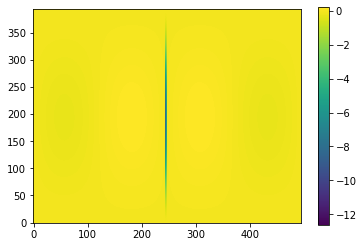

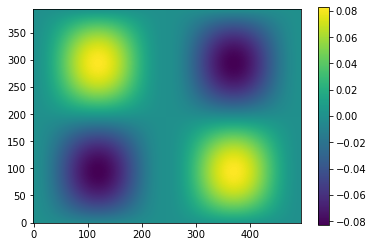

In [6]:
# Numerical derivation:

ndpadx = np.zeros_like(pa)
ndpady = np.zeros_like(pa)

for i in range(1, sim_args["nx"]+2):
    for j in range(1, sim_args["ny"]+2):
        ndpadx[j, i] = (pa[j ,i+1] - pa[j ,i-1])/(x[2] - x[0]) 
        ndpady[j, i] = (pa[j+1, i] - pa[j-1, i])/(y[2] - y[0]) 

fig = plt.figure()
plt.imshow(ndpadx, origin="lower")
plt.colorbar()

fig = plt.figure()
plt.imshow(ndpady, origin="lower")
plt.colorbar()

fig = plt.figure()
plt.imshow(ndpadx[5:-5, 5:-5]-dpadx[5:-5, 5:-5], origin="lower")
plt.colorbar()

fig = plt.figure()
plt.imshow(ndpady[5:-5, 5:-5] - dpady[5:-5, 5:-5], origin="lower")
plt.colorbar()




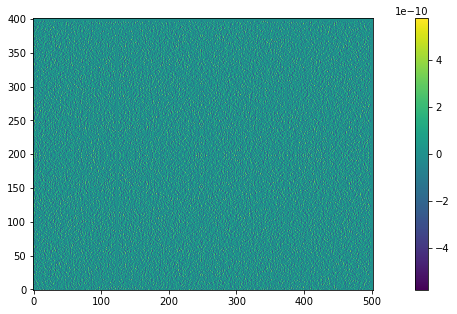

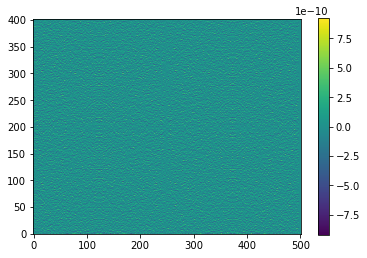

In [7]:
indpadx = np.zeros_like(pa)
indpady = np.zeros_like(pa)

for i in range(1, sim_args["nx"]+2):
    for j in range(1, sim_args["ny"]+2):
        pae = 0.5*(pa[j, i] + pa[j, i+1])
        paw = 0.5*(pa[j, i] + pa[j, i-1])
        pan = 0.5*(pa[j, i] + pa[j+1, i])
        pas = 0.5*(pa[j, i] + pa[j-1, i])

        indpadx[j, i] = (pae - paw)/(x[1] - x[0]) 
        indpady[j, i] = (pan - pas)/(y[1] - y[0])



fig = plt.figure(figsize=(15,5))
plt.imshow(ndpadx[1:-1, 1:-1] - indpadx[1:-1, 1:-1], origin="lower")
plt.colorbar()

fig = plt.figure()
plt.imshow(ndpady[1:-1, 1:-1] - indpady[1:-1, 1:-1], origin="lower")
plt.colorbar()


In [8]:
p_init = np.array([[0]], np.float32)
p_init.shape, p_init[0, 0]

((1, 1), 0.0)

### Make test sim 

In [16]:
def sim_animation(sim, T, anim_dt, hu_max=20.0, eta_max=0.5):
    """
    Creates an animation of the simulator based on T frames, with frames sub_dt*sim.dt appart.
    """
    eta1, u1, v1 = sim.download(interior_domain_only=True)
    
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(15, 4))
    domain_extent = [0, sim.nx*sim.dx, 0, sim.ny*sim.dy]
    
    ax_eta = plt.subplot(1,3,1)
    sp_eta = ax_eta.imshow(eta1, interpolation="none", origin='lower', vmin=-eta_max, vmax=eta_max, extent=domain_extent)
    plt.title('eta')
    fig.colorbar(sp_eta)
    
    ax_u = plt.subplot(1,3,2)
    sp_u = ax_u.imshow(u1, interpolation="none", origin='lower', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    plt.title('hu')
    fig.colorbar(sp_u)
    
    ax_v = plt.subplot(1,3,3)
    sp_v = ax_v.imshow(v1, interpolation="none", origin='lower', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    plt.title('hv')
    fig.colorbar(sp_v)
    
    #Helper function which simulates and plots the solution
    def animate(i):
        if (i>0):
            t = sim.step(anim_dt)
        else:
            t = 0.0
        eta1, u1, v1 = sim.download(interior_domain_only=True)

        #Update plots
        fig.sca(ax_eta)
        sp_eta.set_data(eta1)

        fig.sca(ax_u)
        sp_u.set_data(u1)

        fig.sca(ax_v)
        sp_v.set_data(v1)

        fig.suptitle("Time = {:04.0f} h ({:s})".format(t/3600, sim.__class__.__name__), fontsize=18)
        print(".", end='')

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
    plt.close(fig)
    return anim

In [13]:
if 'sim' in globals():
    sim.cleanUp()

reload(CDKLM16)
reload(AtmosphericPressure)

sim = CDKLM16.CDKLM16(**sim_args, **init_args, 
                      atmospheric_pressure=AtmosphericPressure.AtmosphericPressure(P=[pa]))


In [78]:
sim_animation(sim, 24*3, 3600)

In [18]:
sim.t, 24*3600, sim.dt

eta1, hu1, hv1 = sim.download(interior_domain_only=True)
print(np.abs(hu1).max())

2.230288


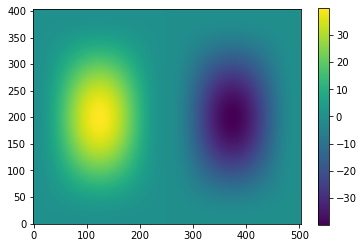

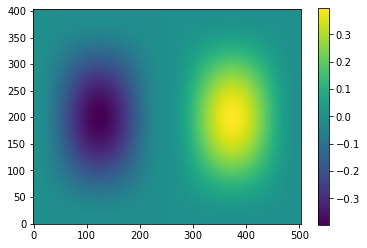

In [19]:
fig = plt.figure()
plt.imshow(pa/100, origin="lower")
plt.colorbar()

fig = plt.figure()
plt.imshow(balanced_init_args["eta0"], origin="lower")
plt.colorbar()



In [82]:
if 'balanced_sim' in globals():
    balanced_sim.cleanUp()

reload(CDKLM16)

balanced_sim = CDKLM16.CDKLM16(**sim_args, **balanced_init_args, 
                      atmospheric_pressure=AtmosphericPressure.AtmosphericPressure(P=[pa]))
sim_animation(balanced_sim, 24, 3600*10, hu_max=0.01)


In [23]:
eta1, hu1, hv1 = balanced_sim.download(interior_domain_only=True)
print(np.abs(hu1).max(), np.abs(hv1).max())

0.39152437 0.27989513


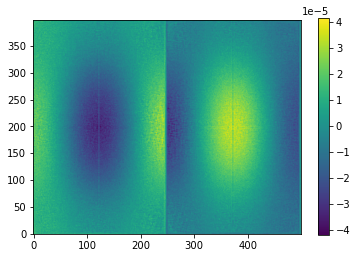

In [24]:
plt.imshow(balanced_init_args["eta0"][2:-2, 2:-2] - eta1, origin="lower")
plt.colorbar()

In [81]:
if 'balanced_sim_x' in globals():
    balanced_sim_x.cleanUp()

reload(CDKLM16)

balanced_sim_x = CDKLM16.CDKLM16(**sim_args, **balanced_init_args_linx,  
                      atmospheric_pressure=AtmosphericPressure.AtmosphericPressure(P=[pa_linear_x]))
sim_animation(balanced_sim_x, 24, 3600*10, hu_max=0.01)
#balanced_sim_x.step(3600)
#eta1, hu1, hv1 = balanced_sim_x.download(interior_domain_only=True)
#print(np.abs(hu1).max(), np.abs(hv1).max(), np.abs(balanced_init_args_linx["eta0"][2:-2, 2:-2] - eta1).max())

0.012500725 0.0 1.0833144e-05
0.0002740008 0.0 1.0833144e-05


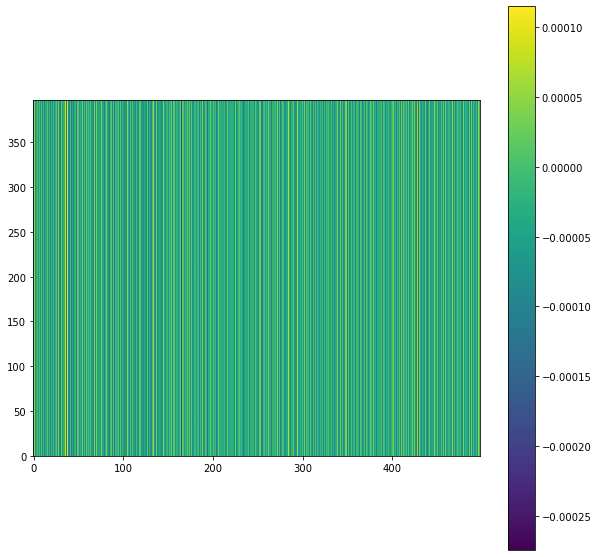

In [26]:
eta1, hu1, hv1 = balanced_sim_x.download(interior_domain_only=True)
fig = plt.figure(figsize=(10,10))
plt.imshow(hu1[1:-1, 1:-1], origin="lower")
#plt.imshow(hu1, origin="lower")
plt.colorbar()
print(np.abs(hu1).max(), np.abs(hv1).max(), np.abs(balanced_init_args_linx["eta0"][2:-2, 2:-2] - eta1).max())
print(np.abs(hu1[1:-1, 1:-1]).max(), np.abs(hv1[1:-1, 1:-1]).max(), np.abs(balanced_init_args_linx["eta0"][3:-3, 3:-3] - eta1[1:-1,1:-1]).max())

In [83]:
if 'balanced_sim_y' in globals():
    balanced_sim_y.cleanUp()

reload(CDKLM16)

balanced_sim_y = CDKLM16.CDKLM16(**sim_args, **balanced_init_args_liny,  
                      atmospheric_pressure=AtmosphericPressure.AtmosphericPressure(P=[pa_linear_y]))
sim_animation(balanced_sim_y, 24, 3600*10, hu_max=0.01)


0.0 0.015551984 1.17868185e-05
0.0 0.00019342091 1.17868185e-05


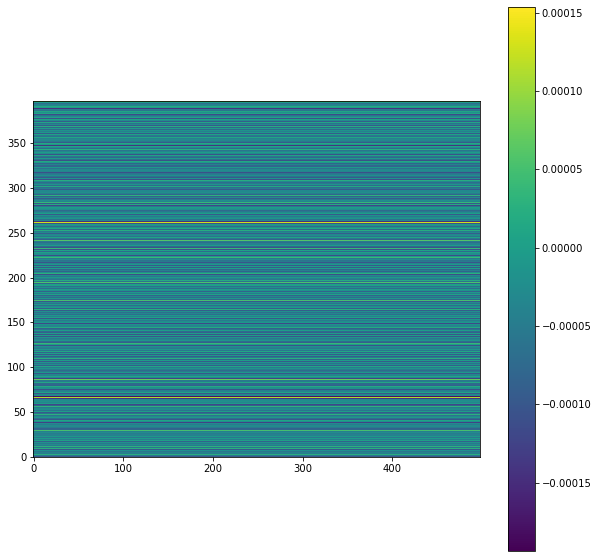

In [28]:
eta1, hu1, hv1 = balanced_sim_y.download(interior_domain_only=True)
fig = plt.figure(figsize=(10,10))
plt.imshow(hv1[1:-1, 1:-1], origin="lower")
#plt.imshow(hu1, origin="lower")
plt.colorbar()
print(np.abs(hu1).max(), np.abs(hv1).max(), np.abs(balanced_init_args_liny["eta0"][2:-2, 2:-2] - eta1).max())
print(np.abs(hu1[1:-1, 1:-1]).max(), np.abs(hv1[1:-1, 1:-1]).max(), np.abs(balanced_init_args_liny["eta0"][3:-3, 3:-3] - eta1[1:-1,1:-1]).max())

In [84]:
if 'balanced_sim_xy' in globals():
    balanced_sim_xy.cleanUp()

reload(CDKLM16)

balanced_sim_xy = CDKLM16.CDKLM16(**sim_args, **balanced_init_args_linxy, 
                      atmospheric_pressure=AtmosphericPressure.AtmosphericPressure(P=[pa_linear_xy]))
sim_animation(balanced_sim_xy, 24, 3600*10, hu_max=0.01)
#eta1, hu1, hv1 = balanced_sim_xy.download(interior_domain_only=True)
#print(np.abs(hu1).max(), np.abs(hv1).max(), np.abs(balanced_init_args_linxy["eta0"][2:-2, 2:-2] - eta1).max())

0.007151054 0.0071464134 1.0415912e-05
0.002035294 0.0016144884 1.0415912e-05


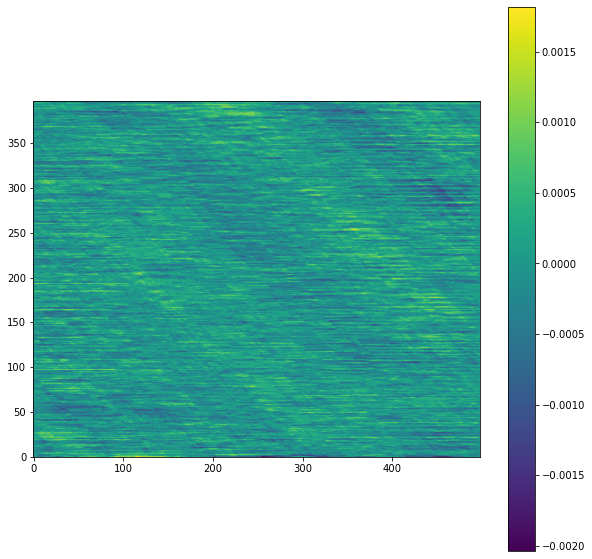

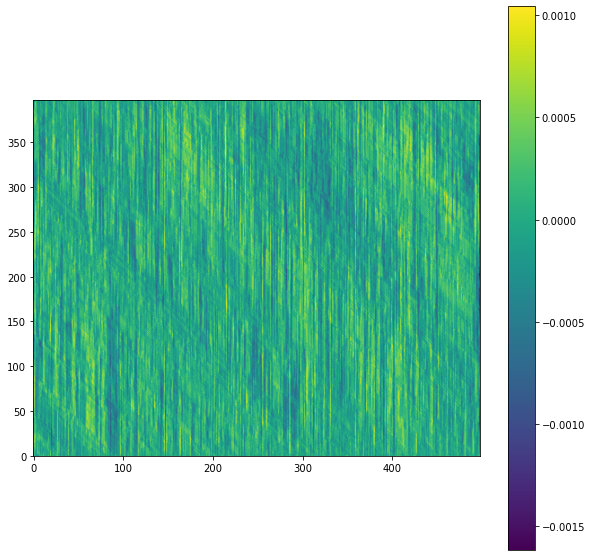

In [31]:
eta1, hu1, hv1 = balanced_sim_xy.download(interior_domain_only=True)
fig = plt.figure(figsize=(10,10))
plt.imshow(hu1[1:-1, 1:-1], origin="lower")
plt.colorbar()
fig = plt.figure(figsize=(10,10))
plt.imshow(hv1[1:-1, 1:-1], origin="lower")
#plt.imshow(hu1, origin="lower")
plt.colorbar()
print(np.abs(hu1).max(), np.abs(hv1).max(), np.abs(balanced_init_args_linxy["eta0"][2:-2, 2:-2] - eta1).max())
print(np.abs(hu1[1:-1, 1:-1]).max(), np.abs(hv1[1:-1, 1:-1]).max(), np.abs(balanced_init_args_linxy["eta0"][3:-3, 3:-3] - eta1[1:-1,1:-1]).max())

# Time dependent pressure

In [70]:
def makeTimeDependentPressure(p, p_factor_handle, a, b, numSamples):
    P = [None]*numSamples
    t = [None]*numSamples
    for i in range(numSamples):
        t[i] = a + i*b/(numSamples-1)
        P[i] = p*p_factor_handle(t[i])
    return AtmosphericPressure.AtmosphericPressure(t=t, P=P)




In [85]:
if 'temporal_sim_xy' in globals():
    temporal_sim_xy.cleanUp()

reload(CDKLM16)
num_p_samples = 10 # Results get worse with fewer samples 
p_atm_factor_handle = lambda t : min(t/(24.0*3600), 1.0)
#p_atm_factor_handle = lambda t : min((t-2*3600)/(4.0*3600), 1.0)
temporal_sim_xy = CDKLM16.CDKLM16(**sim_args, **init_args,
                                  atmospheric_pressure=makeTimeDependentPressure(pa, p_atm_factor_handle, 0, 24*3600, num_p_samples))
sim_animation(temporal_sim_xy, 48, 3600, hu_max=1)


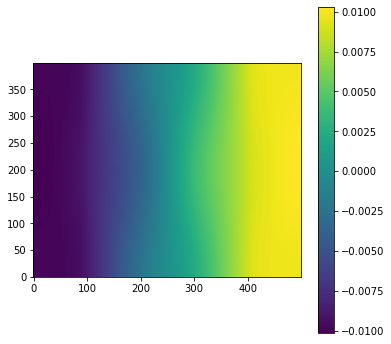

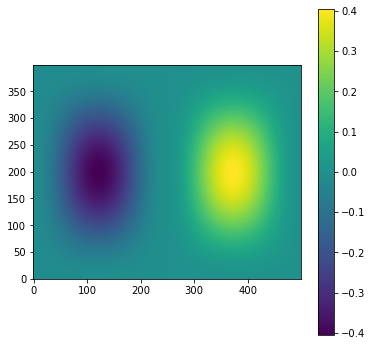

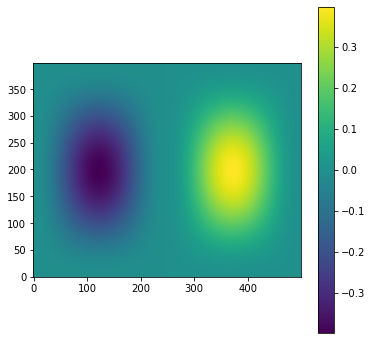

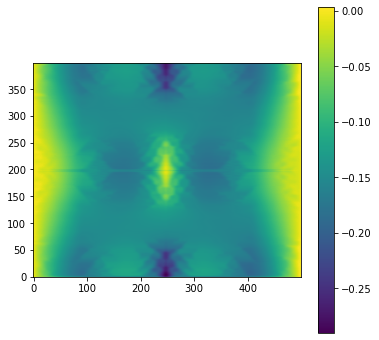

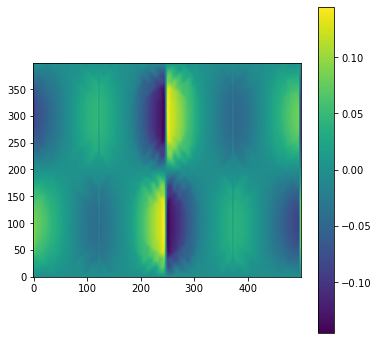

In [72]:
temporal_sim_xy.step(3600*3*24)
eta1, hu1, hv1 = temporal_sim_xy.download(interior_domain_only=True)
fig = plt.figure(figsize=(6,6))
plt.imshow(eta1 - balanced_init_args["eta0"][2:-2,2:-2], origin="lower")
plt.colorbar()
fig = plt.figure(figsize=(6,6))
plt.imshow(eta1, origin="lower")
plt.colorbar()
fig = plt.figure(figsize=(6,6))
plt.imshow(balanced_init_args["eta0"][2:-2,2:-2], origin="lower")
plt.colorbar()
fig = plt.figure(figsize=(6,6))
plt.imshow(hu1, origin="lower")
plt.colorbar()
fig = plt.figure(figsize=(6,6))
plt.imshow(hv1, origin="lower")
plt.colorbar()

# Time dependent from one non-zero steady state to another

In [86]:
if 'temporal_sim_2' in globals():
    temporal_sim_2.cleanUp()

reload(CDKLM16)
p_time = 1.5*24*3600/5
p_atm_factor_handle = lambda t : min((t-p_time)/(p_time), 1.0)
#p_atm_factor_handle = lambda t : min((t-2*3600)/(4.0*3600), 1.0)
temporal_sim_2 = CDKLM16.CDKLM16(**sim_args, **balanced_init_args, #p_atm=-pa,
                                  #p_atm_factor_handle=p_atm_factor_handle)
                                atmospheric_pressure=makeTimeDependentPressure(-pa, p_atm_factor_handle, 0, 2*p_time, num_p_samples))

sim_animation(temporal_sim_2, 24*2, 2*3600/5, hu_max=1)


0.20650612 0.3571822 0.007319575


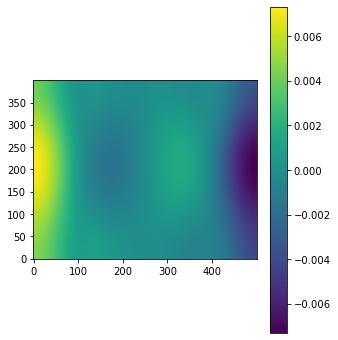

In [74]:
eta1, hu1, hv1 = temporal_sim_2.download(interior_domain_only=True)
print(np.abs(hu1).max(), np.abs(hv1).max(), np.abs(balanced_init_args["eta0"][2:-2, 2:-2] + eta1).max())
fig = plt.figure(figsize=(5,6))
plt.imshow(eta1 + balanced_init_args["eta0"][2:-2,2:-2], origin="lower")
plt.colorbar()

0.16929117 0.0 0.024451733


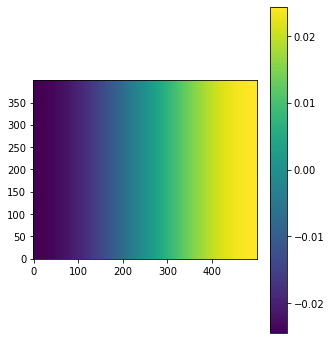

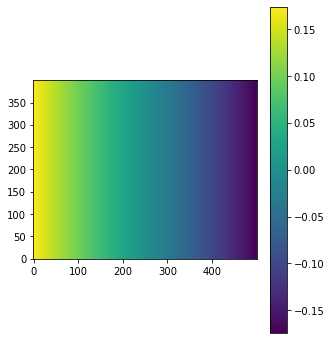

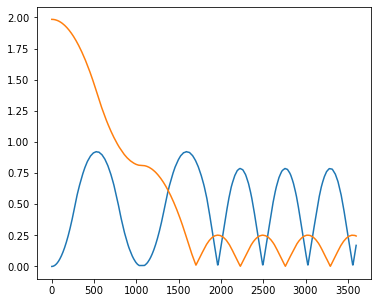

In [75]:
if 'temporal_sim_3' in globals():
    temporal_sim_3.cleanUp()

from gpuocean.SWEsimulators import Simulator
reload(Simulator)
reload(CDKLM16)
reload(AtmosphericPressure)
p_atm_factor_handle = lambda t : min((t-0)/(12*3600), 1.0)
#p_atm_factor_handle = lambda t : min((t-2*3600)/(4.0*3600), 1.0)
temporal_sim_3 = CDKLM16.CDKLM16(**sim_args, **init_args,
                                  atmospheric_pressure=makeTimeDependentPressure(pa_linear_x, p_atm_factor_handle, 0, 12*3600, 10))


max_hu = np.zeros(3600)
max_eta_diff = np.zeros(3600)
ref_eta1 = balanced_init_args_linx["eta0"][2:-2, 2:-2] - np.mean(balanced_init_args_linx["eta0"][2:-2, 2:-2])
for i in range(3600):
    temporal_sim_3.step(24)
    eta, hu, _ = temporal_sim_3.download(interior_domain_only=True)
    max_hu[i] = np.abs(hu).max()
    max_eta_diff[i] = np.abs(eta - ref_eta1).max()


eta1, hu1, hv1 = temporal_sim_3.download(interior_domain_only=True)
print(np.abs(hu1).max(), np.abs(hv1).max(), np.abs(ref_eta1 - eta1).max())
fig = plt.figure(figsize=(5,6))
plt.imshow(eta1 - ref_eta1, origin="lower")
plt.colorbar()
fig = plt.figure(figsize=(5,6))
plt.imshow(eta1, origin="lower")
plt.colorbar()

fig = plt.figure(figsize=(6,5))
plt.plot(max_hu)
plt.plot(max_eta_diff*10)
